<a href="https://colab.research.google.com/github/iRahulPandey/medium-articles/blob/master/Grid_%26_Random_Search_Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to ace machine learning model optimization

This notebook is intended to explore different optimization techniques for ML models such as:


1. Grid Search
2. Random Search
3. Baysian Search

Fake data generation

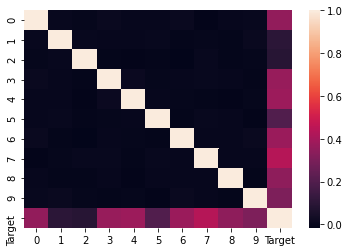

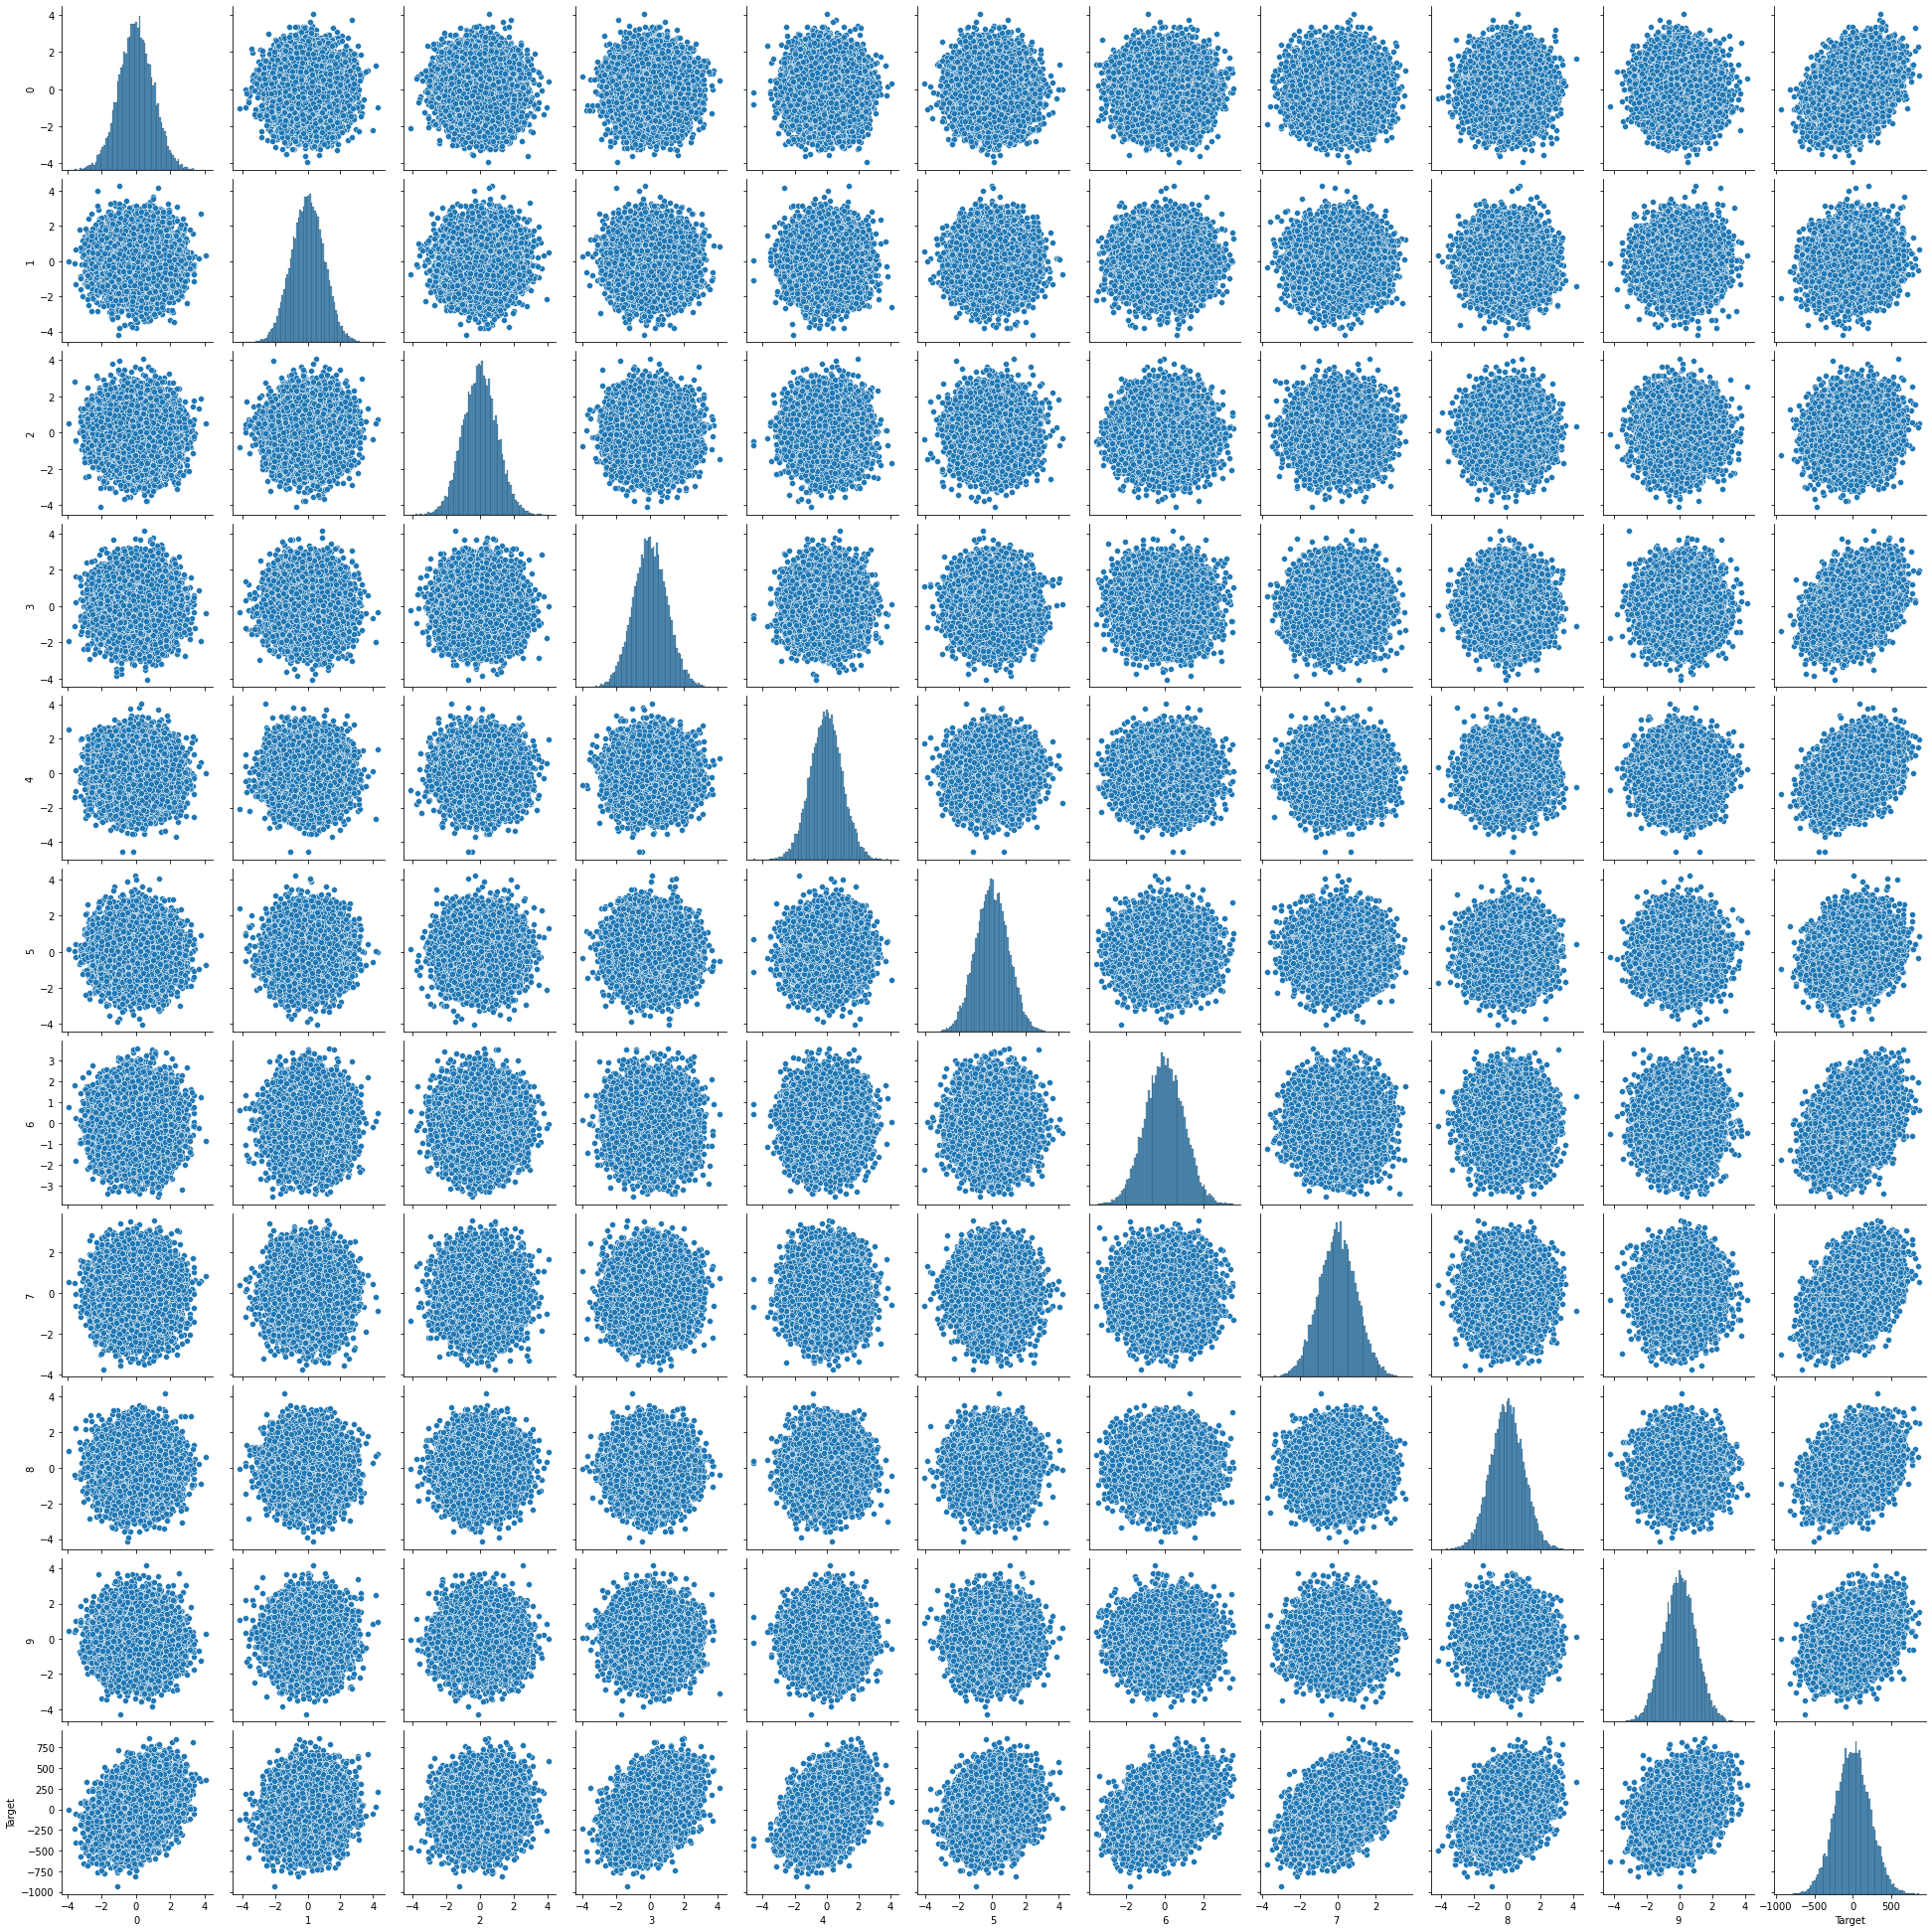

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression 
import matplotlib.pyplot as plt
import seaborn as sns

# create dataset
X, y = make_regression(n_samples=20000, n_features=10, noise=0.5)

# create dataframe
df = pd.DataFrame(data=X)
df['Target'] = y

# correlation between features
sns.heatmap(df.corr())

# pairplot to see the distribution
sns.pairplot(df)

In [2]:
# create features and target
features = df.drop(columns=['Target'])
target = df['Target']

# shape
print(features.shape)
print(target.shape)

# Split dataset
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 5000, random_state=0)

# splitted data
print("Number of training examples "+ str(X_train.shape[0]))
print("Number of test examples "+ str(X_test.shape[0]))

(20000, 10)
(20000,)
Number of training examples 15000
Number of test examples 5000


# Grid Search

First let's take an example of GridSearch
</br>
In this section we will see How we can perform gridsearch with and without GridSearchCV

In [3]:
# Modeling
import lightgbm as lgb

# Import gridsearch and Random search
from sklearn.model_selection import GridSearchCV, RepeatedKFold

WIth and Without GridSearchCV - Lightgbm

Four methods for Hyperparameter tuning: <br>
It's helpful to think of hyperparameter tuning as having four parts (these four parts also will form the basis of Bayesian Optimization):

- Objective function: a function that takes in hyperparameters and returns a score we are trying to minimize or maximize
- Domain: the set of hyperparameter values over which we want to search.
- Algorithm: method for selecting the next set of hyperparameters to evaluate in the objective function.
- Results history: data structure containing each set of hyperparameters and the resulting score from the objective function.

In [4]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)

## Objective function

In [5]:
# create objective function that implements early stopping
def objective(hyperparameters, iteration):
   
    # Delete n_estimators as it will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    

    # n_folds cross validation
    if hyperparameters['boosting_type'] == 'dart':
      cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, 
                      metrics = 'rmse', nfold = 10, seed = 0, stratified=False)
    else:  
      cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                        metrics = 'rmse', nfold = 10, seed = 0, stratified=False) #remove stratified=False when training classifiers 
    # results to retun
    score = cv_results['rmse-mean'][-1]
    estimators = len(cv_results['rmse-mean'])
    hyperparameters['n_estimators'] = estimators 

    return [score, hyperparameters, iteration]

## Domain definition

In [6]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

## Algorithm function

In [7]:
import itertools

# define maximum cobinations otherwise with huge parameter space it will take huge amount of time to search
MAX_EVALS = 10

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # list of all possible combinations from domain
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # print(hyperparameters)
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results 

## Result - Train and Evaluate

In [8]:
# start search
grid_results = grid_search(param_grid)

In [9]:
# check the result
grid_results

,index,score,params,iteration
0,0,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0
1,1,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",1
2,2,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",2
3,3,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",3
4,4,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",4
5,5,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",5
6,6,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",6
7,7,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",7
8,8,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",8
9,9,18.0281,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",9


In [10]:
# print the parameters
print('The best validation mean RMSE score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nBest hyperparameters for lowest RMSE were :')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation mean RMSE score was 18.02809

Best hyperparameters for lowest RMSE were :
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 10000,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [11]:
# import 
from sklearn.metrics import mean_squared_error

# Get the best parameters
grid_search_params = grid_results[grid_results.score == grid_results.score.min()].loc[0, 'params']

# Create, train, test model
model = lgb.LGBMRegressor(**grid_search_params, random_state=0)

# Train 
model.fit(X_train, y_train)

# predict
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print('The model RMSE score {:.5f} on the test set.'.format(rmse))

The model RMSE score 17.22678 on the test set.


Implementing Sklearn GridSearchCV

In [12]:
# import
from sklearn.model_selection import GridSearchCV, RepeatedKFold

# create a small version of parameter grid defined in Domain and name it as search space - Taking best parameter with little variation in number of leaves and number of estimators
search_space = {
    'boosting_type': ['gbdt'],
    'num_leaves': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.005],
    'subsample_for_bin': [20000],
    'min_child_samples': [15],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'colsample_bytree': [0.6], #list(np.linspace(0.5, 0.6, 2)),
    'subsample': [0.5], #[0.4, 0.5],
    'is_unbalance': [True],
    'n_estimators': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
}

In [13]:
# use gridsearchcv from sklearn library
model = lgb.LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=0)

# train model
# note: GridSearchCV is maximizing the scoring, hence it is used neg_rmse
cv_results = GridSearchCV(model, search_space, scoring='neg_root_mean_squared_error', cv=cv).fit(X_train,y_train)

So what's happening in the Grid Search - Lets plot

In [14]:
# create dataframe
score_df = pd.DataFrame(data=zip(cv_results.cv_results_['param_n_estimators'].data, cv_results.cv_results_['param_num_leaves'].data, -cv_results.cv_results_['mean_test_score'], cv_results.cv_results_['std_test_score']), columns=['number of estimators', 'number of leaves', 'mean rmse', 'std rmse'])

In [100]:
import plotly.express as px


fig = px.scatter(score_df, x="number of estimators", y="number of leaves",
                 color="mean rmse", color_continuous_scale="rainbow", 
                 size="std rmse", width=600, height=500,
                 range_color=[5,55])

# Best esitmator
fig.add_scatter(x = [10000], y=[4], mode="markers", showlegend=False, marker={'size': 18, 'color': ['gray'], 'symbol' : 'star', 'line' : dict(
                color='black',
                width=2
            )})

# format axis
fig.update_layout(xaxis_range=[0,11000],
                                   
                  font=dict(
                  family="Arial",
                  size=16,
                  color="black")
                  
                  )

# change background
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

# Change grid lines color
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.show()

use best parameter from gridsearchcv on test data

In [16]:
# Best score acheived using gridsearch on train dataset
print('The best validation mean RMSE score was {:.5f}'.format(-cv_results.best_score_))

# Best model hyperparameters
print("\nBest hyperparameters for lowest RMSE were :")
print(cv_results.best_estimator_)

The best validation mean RMSE score was 18.54345

Best hyperparameters for lowest RMSE were :
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', is_unbalance=True, learning_rate=0.005,
              max_depth=-1, min_child_samples=15, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=4,
              objective=None, random_state=None, reg_alpha=0, reg_lambda=0,
              silent=True, subsample=0.5, subsample_for_bin=20000,
              subsample_freq=0)


In [17]:
# import 
from sklearn.metrics import mean_squared_error

# Get the best parameters
grid_search_cv_params = cv_results.best_estimator_.get_params()

# assign random state to 0
grid_search_cv_params['random_state'] = 0

# Create, train, test model
model = lgb.LGBMRegressor(**grid_search_cv_params)

# Train 
model.fit(X_train, y_train)

# predict
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print('The model RMSE score {:.5f} on the test set.'.format(rmse))


The model RMSE score 16.42866 on the test set.


# Random Search

https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search

Random search wasn’t taken very seriously before. This is because it doesn’t search over all the grid points, so it cannot possibly beat the optimum found by grid search. But then came along Bergstra and Bengio. They showed that, in surprisingly many instances, random search performs about as well as grid search. All in all, trying 60 random points sampled from the grid seems to be good enough.

In hindsight, there is a simple probabilistic explanation for the result: for any distribution over a sample space with a finite maximum, the maximum of 60 random observations lies within the top 5% of the true maximum, with 95% probability. That may sound complicated, but it’s not. Imagine the 5% interval around the true maximum. Now imagine that we sample points from his space and see if any of it lands within that maximum. Each random draw has a 5% chance of landing in that interval, if we draw n points independently, then the probability that all of them miss the desired interval is (1−0.05)n. So the probability that at least one of them succeeds in hitting the interval is 1 minus that quantity. We want at least a .95 probability of success. To figure out the number of draws we need, just solve for n in the equation:

1−(1−0.05)n>0.95

We get n⩾60. Ta-da!

The moral of the story is: if the close-to-optimal region of hyperparameters occupies at least 5% of the grid surface, then random search with 60 trials will find that region with high probability

# Algorithm function

In [18]:
import random

# create function for random search
def random_search(param_grid, max_evals = MAX_EVALS):

    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

# Train and Evaluate

In [19]:
# start random search
random_results = random_search(param_grid)

In [21]:
random_results

,index,score,params,iteration
0,8,159.863,"{'boosting_type': 'goss', 'num_leaves': 22, 'l...",8
1,7,155.488,"{'boosting_type': 'goss', 'num_leaves': 135, '...",7
2,0,148.985,"{'boosting_type': 'goss', 'num_leaves': 134, '...",0
3,5,148.272,"{'boosting_type': 'goss', 'num_leaves': 128, '...",5
4,3,144.855,"{'boosting_type': 'goss', 'num_leaves': 131, '...",3
5,1,34.2418,"{'boosting_type': 'dart', 'num_leaves': 138, '...",1
6,4,28.1212,"{'boosting_type': 'gbdt', 'num_leaves': 122, '...",4
7,9,27.7847,"{'boosting_type': 'gbdt', 'num_leaves': 142, '...",9
8,2,27.2235,"{'boosting_type': 'dart', 'num_leaves': 144, '...",2
9,6,22.4263,"{'boosting_type': 'gbdt', 'num_leaves': 127, '...",6


In [20]:
# find best parameter
print('The best validation mean RMSE score was {:.5f}'.format(random_results.loc[9, 'score']))
print('\nBest hyperparameters for lowest RMSE were :')

import pprint
pprint.pprint(random_results.loc[9, 'params'])

The best validation mean RMSE score was 22.42632

Best hyperparameters for lowest RMSE were :
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7777777777777778,
 'is_unbalance': True,
 'learning_rate': 0.022367665272492326,
 'min_child_samples': 255,
 'n_estimators': 9938,
 'num_leaves': 127,
 'reg_alpha': 0.4693877551020408,
 'reg_lambda': 0.2857142857142857,
 'subsample': 0.6363636363636364,
 'subsample_for_bin': 260000}


In [22]:
# Get the best parameters
random_search_params = random_results[random_results.score == random_results.score.min()].loc[9, 'params']

# Create, train, test model
model = lgb.LGBMRegressor(**random_search_params, random_state=0)

# Train 
model.fit(X_train, y_train)

# predict
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print('The model RMSE score {:.5f} on the test set.'.format(rmse))

The model RMSE score 22.24084 on the test set.


As it can be seen that with 10 iteration similar to grid search, Random search explored more regions. However RMSE is higher but Random search offers efficiency in terms of searching over large search space in short time compared to Grid search. 

Now lets take an example of similar search space 

Implementing Sklearn RandomSearchCV on search space and compare it to GridSearchCV 

In [24]:
# library
from sklearn.model_selection import RandomizedSearchCV

# use repeatedfold from sklearn library
model = lgb.LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=0)

# train model
# note: RandomizedSearchCV is maximizing the scoring, hence it is used neg_rmse
# Here i Will use 60 itration for Random search 
# Remeber search space with n_estimators=19 and n_leaves=10
# Grid search tries all 190 combinations --> computation intensive
# To test Random search I will run for 60 iteration and then 100 iteration and see how close we get to the best parameters
RandomizedSearchCV_results = RandomizedSearchCV(model, search_space, n_iter=60, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv).fit(X_train,y_train)

In [25]:
# create dataframe
RandomizedSearchCV_df = pd.DataFrame(data=zip(RandomizedSearchCV_results.cv_results_['param_n_estimators'].data, RandomizedSearchCV_results.cv_results_['param_num_leaves'].data, -RandomizedSearchCV_results.cv_results_['mean_test_score'], RandomizedSearchCV_results.cv_results_['std_test_score']), columns=['number of estimators', 'number of leaves', 'mean rmse', 'std rmse'])

In [98]:
import plotly.express as px


fig = px.scatter(RandomizedSearchCV_df, x="number of estimators", y="number of leaves",
                 color="mean rmse", color_continuous_scale="rainbow", 
                 size="std rmse", width=600, height=500,
                 range_color=[5,55])

# Best esitmator
fig.add_scatter(x = [10000], y=[8], mode="markers", showlegend=False, marker={'size': 18, 'color': ['#ff6666'], 'symbol' : 'star', 'line' : dict(
                color='black',
                width=2
            )})

# format axis
fig.update_layout(xaxis_range=[0,11000],
                                   
                  font=dict(
                  family="Arial",
                  size=16,
                  color="black")
                  
                  )

# change background
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

# Change grid lines color
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.show()

In [30]:
# Best score acheived using RandomizedSearchCV_df on train dataset
print('The best validation mean RMSE score was {:.5f}'.format(-RandomizedSearchCV_results.best_score_))

# Best model hyperparameters
print("\nBest hyperparameters for lowest RMSE were :")
print(RandomizedSearchCV_results.best_estimator_)

The best validation mean RMSE score was 13.79877

Best hyperparameters for lowest RMSE were :
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', is_unbalance=True, learning_rate=0.005,
              max_depth=-1, min_child_samples=15, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=8,
              objective=None, random_state=None, reg_alpha=0, reg_lambda=0,
              silent=True, subsample=0.5, subsample_for_bin=20000,
              subsample_freq=0)


Use the best parameter to train model

In [31]:
# import 
from sklearn.metrics import mean_squared_error

# Get the best parameters
randomized_search_cv_params = RandomizedSearchCV_results.best_estimator_.get_params()

# assign random state to 0
randomized_search_cv_params['random_state'] = 0

# Create, train, test model
model = lgb.LGBMRegressor(**randomized_search_cv_params)

# Train 
model.fit(X_train, y_train)

# predict
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print('The model RMSE score {:.5f} on the test set.'.format(rmse))


The model RMSE score 16.78236 on the test set.


# Combine Random Search and Grid Search

Narrow down the search area using random search and then use grid search to find the best optimum point in a present search space

In [32]:
# As it can be seen from above that n_estimator = 10000 and n_leaves = 8 was the best parameter found by Random search then use this and make little variation
search_space_from_randomsearch = {
    'boosting_type': ['gbdt'],
    'num_leaves': [6,7,8,9,10],
    'learning_rate': [0.005],
    'subsample_for_bin': [20000],
    'min_child_samples': [15],
    'reg_alpha': [0],
    'reg_lambda': [0],
    'colsample_bytree': [0.6], #list(np.linspace(0.5, 0.6, 2)),
    'subsample': [0.5], #[0.4, 0.5],
    'is_unbalance': [True],
    'n_estimators': [9800, 9900, 10000, 10100, 10200]
}

In [33]:
# use gridsearchcv from sklearn library
model = lgb.LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=0)

# train model
# note: GridSearchCV is maximizing the scoring, hence it is used neg_rmse
cv_results = GridSearchCV(model, search_space_from_randomsearch, scoring='neg_root_mean_squared_error', cv=cv).fit(X_train,y_train)

In [34]:
# create dataframe
gridscore_df = pd.DataFrame(data=zip(cv_results.cv_results_['param_n_estimators'].data, cv_results.cv_results_['param_num_leaves'].data, -cv_results.cv_results_['mean_test_score'], cv_results.cv_results_['std_test_score']), columns=['number of estimators', 'number of leaves', 'mean rmse', 'std rmse'])

In [103]:
import plotly.express as px


fig = px.scatter(gridscore_df, x="number of estimators", y="number of leaves",
                 color="mean rmse", color_continuous_scale="rainbow", 
                 size="std rmse", size_max=11, width=600, height=500,
                 range_color=[5,55])

# Best esitmator
fig.add_scatter(x = [10200], y=[6], mode="markers", showlegend=False, marker={'size': 18, 'color': ['#bada55'], 'symbol' : 'star', 'line' : dict(
                color='black',
                width=2
            )})

# Best esitmator
fig.add_scatter(x = [10000], y=[8], mode="markers", showlegend=False, marker={'size': 18, 'color': ['#ff6666'], 'symbol' : 'star', 'line' : dict(
                color='black',
                width=2
            )})

# Best esitmator
fig.add_scatter(x = [10000], y=[4], mode="markers", showlegend=False, marker={'size': 18, 'color': ['gray'], 'symbol' : 'star', 'line' : dict(
                color='black',
                width=2
            )})

# format axis
fig.update_layout(xaxis_range=[9000,11000],
                  yaxis_range=[0,20],                 
                  font=dict(
                  family="Arial",
                  size=16,
                  color="black")
                  
                  )

# change background
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

# Change grid lines color
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.show()

In [36]:
# Best score acheived using RandomizedSearch+GridSearch on train dataset
print('The best validation mean RMSE score was {:.5f}'.format(-cv_results.best_score_))

# Best model hyperparameters
print("\nBest hyperparameters for lowest RMSE were :")
print(cv_results.best_estimator_)

The best validation mean RMSE score was 18.55528

Best hyperparameters for lowest RMSE were :
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', is_unbalance=True, learning_rate=0.005,
              max_depth=-1, min_child_samples=15, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10200, n_jobs=-1, num_leaves=6,
              objective=None, random_state=None, reg_alpha=0, reg_lambda=0,
              silent=True, subsample=0.5, subsample_for_bin=20000,
              subsample_freq=0)


In [37]:
# import 
from sklearn.metrics import mean_squared_error

# Get the best parameters
grid_search_cv_params = cv_results.best_estimator_.get_params()

# assign random state to 0
grid_search_cv_params['random_state'] = 0

# Create, train, test model
model = lgb.LGBMRegressor(**grid_search_cv_params)

# Train 
model.fit(X_train, y_train)

# predict
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print('The model RMSE score {:.5f} on the test set.'.format(rmse))

The model RMSE score 16.59325 on the test set.
